In [192]:
%load_ext autoreload
%autoreload 2

from finite_state_machine import FiniteStateMachine
from utils import calculate_rate_distortion_curve, create_history_sequences
from complexity_measures import calculate_entropy_and_complexity, empirical_entropy_and_accuracy, calculate_sequence_probabilities, calculate_block_entropies, calculate_joint_prob_dist, mixed_state_presentation, visualize_tree
from visualization import plot_from_transition_matrix

import numpy as np
import matplotlib.pyplot as plt

SEED = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define the Even Process

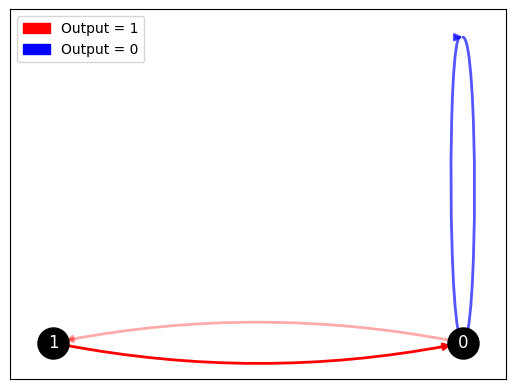

In [204]:
# Define the FSM, this is the even process
transition_function = {'00':0, '11':0, '01':1}
emission_0_probs = np.array([2/3, 0])
fsm = FiniteStateMachine(states=[0,1], transition_function=transition_function,
                            emmision_0_probs=emission_0_probs)

plot_from_transition_matrix(fsm)

(2, 1)
0
1
0
1
0
1
0
1
0
1
0
1
0
1


c:\Users\adamimos\Documents\GitHub\epsilon-transformers\clean_code\complexity_measures.py:300: RuntimeWarning: invalid value encountered in divide
  X_next /= np.sum(X_next)


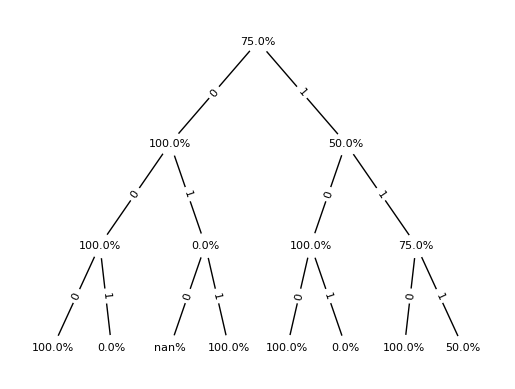

In [213]:
visualize_tree(mixed_state_presentation(fsm, 4))

## Entropy Rate, Statistical Complexity, Joint and Conditional Prob. Dists.

In [175]:
# Calculate entropy rate and statistical complexity
entropy_rate, statistical_complexity = calculate_entropy_and_complexity(fsm)
print(f"Entropy Rate: {entropy_rate}")
print(f"Statistical Complexity: {statistical_complexity}")

from scipy.optimize import minimize_scalar
import numpy as np

def equation(p, X):
    return (p * np.log2(p) + (1-p) * np.log2(1-p) + X) ** 2

def calculate_probability_distribution(X):
    result = minimize_scalar(equation, bounds=(0.01, 0.99), args=(X), method='bounded')
    p = result.x
    return p, 1-p

p, q = calculate_probability_distribution(entropy_rate)
print(f"Probability distribution: p={p}, q={q}")
print(0.75*2/3+0.25)

#stationary distribution
def calculate_stationary_distribution(fsm):
    """
    Calculate the stationary distribution for the FSM.
    """
    transition_matrix, _ = fsm.calculate_transition_matrix()
    eigenvalues, eigenvectors = np.linalg.eig(transition_matrix)
    # find the index of the eigenvalue with the largest absolute value
    idx = np.argmax(np.abs(eigenvalues))
    # find the corresponding eigenvector
    stationary_distribution = np.real(eigenvectors[:, idx])
    # normalize the stationary distribution
    stationary_distribution /= np.sum(stationary_distribution)
    return stationary_distribution

stationary_distribution = calculate_stationary_distribution(fsm)
print(f"Stationary distribution: {stationary_distribution}")

Entropy Rate: 0.6887218755408672
Statistical Complexity: 0.8112781244591328
Probability distribution: p=0.8160140750609695, q=0.18398592493903054
0.75
Stationary distribution: [0.75 0.25]


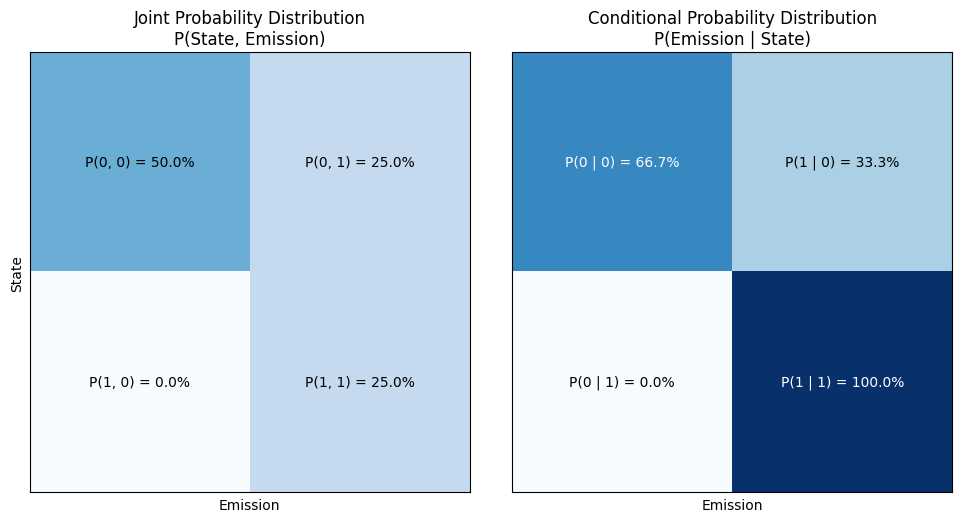

In [170]:

# Calculate joint and conditional probability distribution
joint_prob_dist = calculate_joint_prob_dist(fsm)
conditional_prob_dist = joint_prob_dist / np.sum(joint_prob_dist, axis=1, keepdims=True)

# 2 subplot figure for each prob dist
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.matshow(joint_prob_dist, cmap='Blues', vmin=0, vmax=1)
ax1.set_title('Joint Probability Distribution\nP(State, Emission)')
ax1.set_xlabel('Emission'); ax1.set_ylabel('State')
ax1.set_xticks([]); ax1.set_yticks([])
for (i, j), z in np.ndenumerate(joint_prob_dist):
    percentage = z * 100
    color = 'white' if percentage > 50 else 'black'
    ax1.text(j, i, f'P({i}, {j}) = {z * 100:.1f}%', ha='center', va='center', color=color)

ax2.matshow(conditional_prob_dist, cmap='Blues', vmin=0, vmax=1)
ax2.set_title('Conditional Probability Distribution\nP(Emission | State)')
ax2.set_xlabel('Emission')
ax2.set_xticks([]); ax2.set_yticks([])
for (i, j), z in np.ndenumerate(conditional_prob_dist):
    percentage = z * 100
    color = 'white' if percentage > 50 else 'black'
    ax2.text(j, i, f'P({j} | {i}) = {z * 100:.1f}%', ha='center', va='center', color=color)

plt.tight_layout()

## Rate Distortion Curve

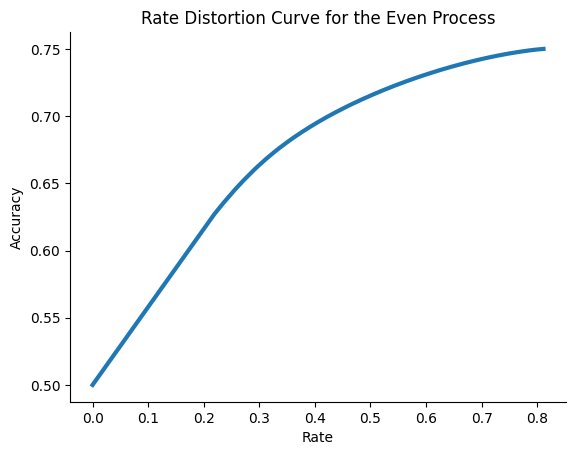

In [6]:
betas = np.linspace(0, 100, 5000)
rate, distortion = calculate_rate_distortion_curve(joint_prob_dist, betas)

# plot the rate distortion curve
plt.plot(rate, distortion, lw=3)
plt.xlabel('Rate')
plt.ylabel('Accuracy')
plt.title('Rate Distortion Curve for the Even Process')
ax = plt.gca(); ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.show()

## Some Simple Testing with GLMs

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

sim_emissions, sim_states = fsm.simulate(30000, seed=SEED)

accuracies = []
entropies = []
for hist_length in np.arange(1, 50):

    # create training, validation, and test sets
    train, val, test = create_history_sequences(sim_emissions, hist_length)
    train_hist, train_next = train[0], train[1]
    val_hist, val_next = val[0], val[1]

    model = LogisticRegression()
    model.fit(train_hist, train_next)

    # Prediction
    train_preds = model.predict(train_hist)
    val_preds = model.predict(val_hist)

    # Accuracy
    train_acc = accuracy_score(train_next, train_preds)
    val_acc = accuracy_score(val_next, val_preds)
    e, a = empirical_entropy_and_accuracy(val_next, val_preds)
    accuracies.append(a)
    entropies.append(e)

c:\Users\adamimos\anaconda3\envs\analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\adamimos\anaconda3\envs\analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

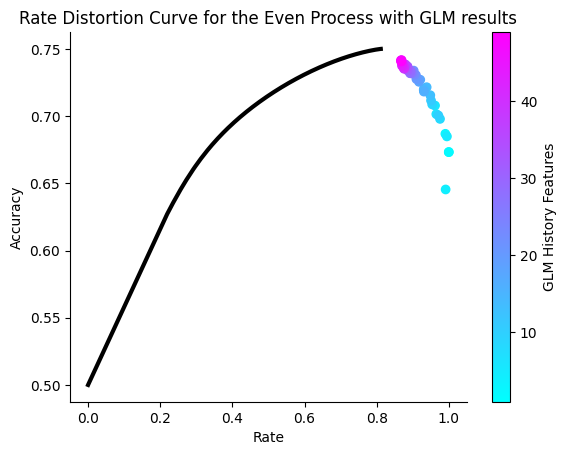

In [8]:
# plot the rate distortion curve
plt.plot(rate, distortion, lw=3, color='black')
plt.xlabel('Rate')
plt.ylabel('Accuracy')
plt.title('Rate Distortion Curve for the Even Process with GLM results')
ax = plt.gca(); ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)

# scatter of the entropies and accuracies just computed, each point with a color corresponding to the history length
sc = plt.scatter(entropies, accuracies, c=np.arange(1, 50), cmap='cool', label='History Length')
cbar = plt.colorbar(sc)
cbar.set_label('GLM History Features')

## Onto Transformers!

In [11]:
import torch
from simple_transformer import Transformer, MultilayerTransformer, set_random_seed

In [179]:
# transformer hyperparameters
history_length = 3
d_vocab = 2
input_size = history_length
d_head = 64
n_head = 4
d_model = d_head*n_head
d_mlp = 4*d_model

sim_emissions, sim_states = fsm.simulate(1000, seed=SEED)


set_random_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"

transformer = MultilayerTransformer(d_vocab, d_model, input_size, d_head, n_head, d_mlp, n_layers=2)
transformer = transformer.to(device)

train, val, test = create_history_sequences(sim_emissions, history_length)
train_hist, train_next = train[0], train[1]
val_hist, val_next = val[0], val[1]
test_hist, test_next = test[0], test[1]

# print out size of the datasets, as well s percentage, all in one line
print(f"Train: {len(train_hist)} ({len(train_hist)/len(sim_emissions):.2%}), Val: {len(val_hist)} ({len(val_hist)/len(sim_emissions):.2%}), Test: {len(test_hist)} ({len(test_hist)/len(sim_emissions):.2%})")
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import tqdm.notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

def evaluate(model, data, targets, criterion):
    model.eval()  # set the model to evaluation mode
    with torch.no_grad():  # do not compute gradients
        predictions = model(data)
        predictions = predictions[:, -1, :]
        loss = criterion(predictions, targets)
        accuracy = (predictions.argmax(dim=1) == targets).float().mean()
        entropy, accuracy_empirical = empirical_entropy_and_accuracy(np.array(targets.cpu()), predictions.argmax(dim=1).cpu().numpy())
    return loss, accuracy, entropy, accuracy_empirical

# Hyperparameters
num_epochs = 10
learning_rate = 1e-5
batch_size = 16

# Convert to torch tensors
train_hist = torch.from_numpy(train_hist).long().to(device) # batch_size, seq_len
train_next = torch.from_numpy(np.array(train_next)).long().to(device) # batch_size
val_hist = torch.from_numpy(val_hist).long().to(device)
val_next = torch.from_numpy(np.array(val_next)).long().to(device)

# Dataset and DataLoader
dataset = TensorDataset(train_hist, train_next)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=learning_rate, weight_decay=1.)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=.1, patience=50, verbose=True)

# Metrics storage
entropy_values, accuracy_values = [], []
entropy_values_train, accuracy_values_train = [], []
val_losses, train_losses = [], []

# Training loop
pbar = tqdm.tqdm(range(num_epochs), desc='Epoch', position=0)
for epoch in pbar:
    transformer.train()  # set the model to training mode

    for inputs, targets in dataloader:
        optimizer.zero_grad()  # reset gradients

        predictions = transformer(inputs)  # forward pass
        predictions = predictions[:, -1, :]  # we only care about the final prediction

        loss = criterion(predictions, targets)  # calculate loss

        loss.backward()  # backpropagation
        optimizer.step()  # update parameters

        # Evaluate on training and validation data
        val_loss, val_accuracy, val_entropy, val_accuracy_empirical = evaluate(transformer, val_hist, val_next, criterion)
        train_loss, train_accuracy, train_entropy, train_accuracy_empirical = evaluate(transformer, train_hist, train_next, criterion)
        val_losses.append(val_loss.item())
        train_losses.append(train_loss.item())
        
        # Store metrics
        entropy_values.append(val_entropy)
        accuracy_values.append(val_accuracy_empirical)
        entropy_values_train.append(train_entropy)
        accuracy_values_train.append(train_accuracy_empirical)

        # Update the learning rate
        #scheduler.step(val_accuracy)

        # set postfix
        pbar.set_postfix({'loss': loss.item(), 'accuracy': train_accuracy.item(), 'val_accuracy': val_accuracy.item(), 'val_loss': val_loss.item()})


Train: 497 (49.70%), Val: 197 (19.70%), Test: 297 (29.70%)


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

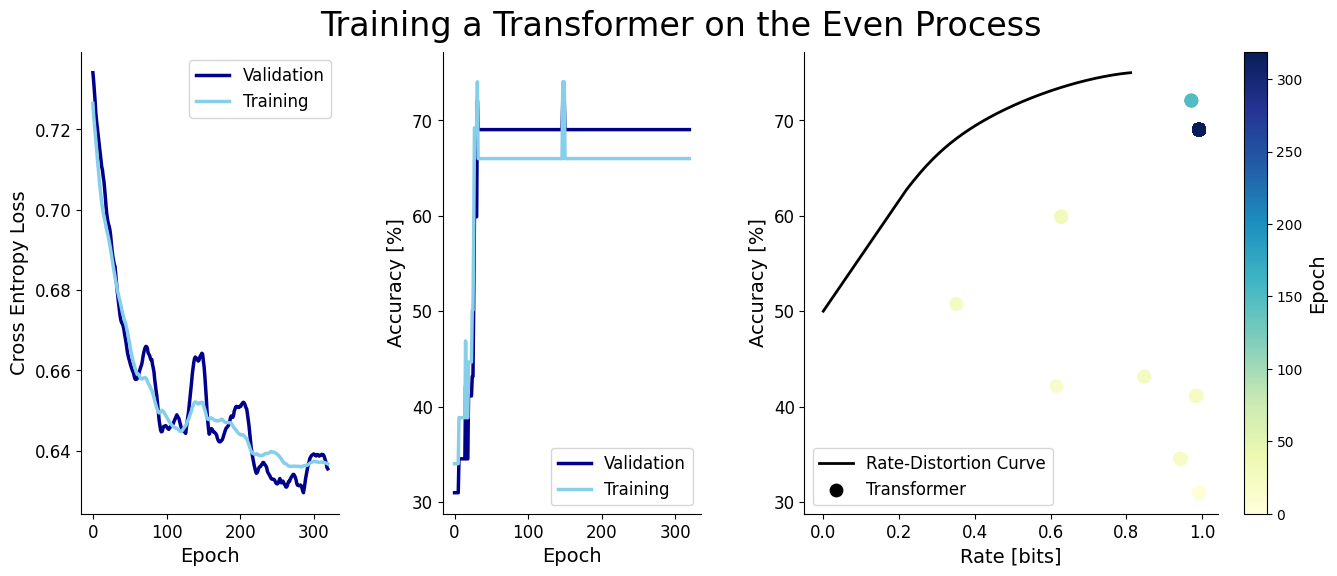

In [180]:
figure, axs = plt.subplots(1, 3, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1, 2]})
figure.suptitle('Training a Transformer on the Even Process', fontsize=24, y=0.95)
n_epochs = len(val_losses)

# Cross Entropy Loss plot
axs[0].plot(np.arange(0, n_epochs), val_losses[:n_epochs], linewidth=2.5, label='Validation', color='darkblue')
axs[0].plot(np.arange(0, n_epochs), train_losses[:n_epochs], linewidth=2.5, label='Training', color='skyblue')
axs[0].legend(loc='upper right', fontsize=12)
axs[0].set_xlabel('Epoch', fontsize=14)
axs[0].set_ylabel('Cross Entropy Loss', fontsize=14)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

# Accuracy plot
axs[1].plot(np.arange(0, n_epochs), 100 * np.array(accuracy_values)[:n_epochs], linewidth=2.5, label='Validation', color='darkblue')
axs[1].plot(np.arange(0, n_epochs), 100 * np.array(accuracy_values_train)[:n_epochs], linewidth=2.5, label='Training', color='skyblue')
axs[1].set_xlabel('Epoch', fontsize=14)
axs[1].set_ylabel('Accuracy [%]', fontsize=14)
axs[1].legend(loc='lower right', fontsize=12)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

# Rate Distortion Curve
# make the line --
axs[2].plot(rate, 100*np.array(distortion), lw=2, color='black', label='Rate-Distortion Curve')
cbar = figure.colorbar(axs[2].scatter(entropy_values, 100*np.array(accuracy_values), c=np.arange(0, n_epochs), cmap='YlGnBu', s=80))
cbar.set_label('Epoch', fontsize=14)
axs[2].set_xlabel('Rate [bits]', fontsize=14)
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].sharey(axs[1])
axs[2].set_ylabel('Accuracy [%]', fontsize=14)
handles, labels = axs[2].get_legend_handles_labels()
handles.append(plt.scatter([], [], c='black', s=80))
labels.append('Transformer')
axs[2].legend(handles=handles, labels=labels, loc='lower left', fontsize=12)




# Adjust spacing between subplots
# make the first two closer than the third
plt.subplots_adjust(wspace=0.3)

# Increase font size of tick labels
for ax in axs:
    ax.tick_params(axis='both', labelsize=12)

plt.show()


[[0.60954314 0.39045694]
 [0.39704275 0.60295725]
 [0.60242516 0.39757484]
 [0.43944204 0.56055796]
 [0.6491402  0.35085982]
 [0.39413622 0.60586375]
 [0.63748235 0.36251763]
 [0.43320948 0.5667905 ]]


tensor([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]])

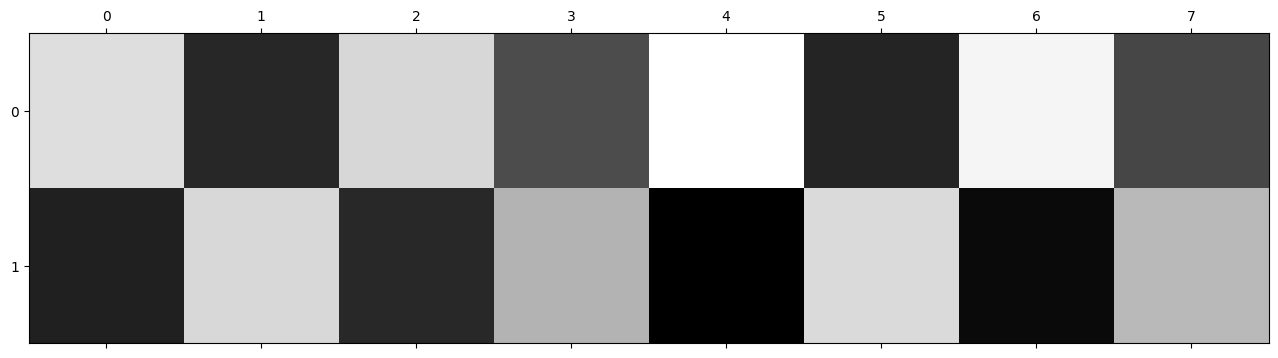

In [181]:
# get all possible 3 bit strings
history_length = 3
import itertools
all_histories = torch.tensor(list(itertools.product([0,1], repeat=history_length))).long()
transformer.to('cpu')
probs = transformer.predict_probs(all_histories)[:, -1, :].detach().numpy()
print(probs)
plt.matshow(probs.T, cmap='gray')
all_histories

{0: 0, 1: 1.0, 2: 1.688721875540867, 3: 2.5786968760216378, 4: 3.267418751562505, 5: 4.111278474345626, 6: 4.800000349886494, 7: 5.56978599859554, 8: 6.258507874136408, 9: 6.984034726540257, 10: 7.672756602081124, 11: 8.377008042956403, 12: 9.06572991849727, 13: 9.760715395720748, 14: 10.449437271261614, 15: 11.140609373998178, 16: 11.829331249539043, 17: 12.518990654134527, 18: 13.207712529675396, 19: 13.89678717711982, 20: 14.585509052660687}


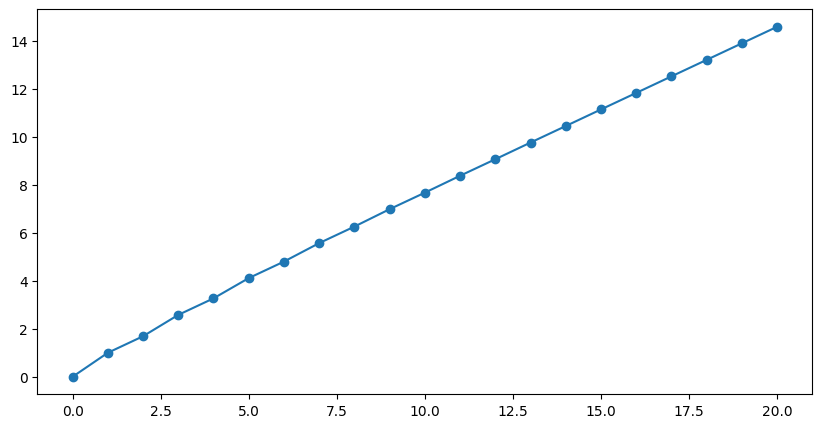

In [183]:
# Test the function
sequence_probs = calculate_sequence_probabilities(fsm, 20)
entropies = calculate_block_entropies(sequence_probs)
print(entropies)

# plot the entropies
plt.figure(figsize=(10, 5))
plt.plot(entropies.keys(), entropies.values(), 'o-')


In [185]:
sequence_probs

{1: {'0': array([0.5]), '1': array([0.25])},
 2: {'00': array([0.33333333]),
  '01': array([0.16666667]),
  '11': array([0.08333333]),
  '10': array([0.16666667])},
 3: {'000': array([0.22222222]),
  '001': array([0.11111111]),
  '011': array([0.16666667]),
  '110': array([0.16666667]),
  '111': array([0.08333333]),
  '100': array([0.11111111]),
  '101': array([0.05555556])},
 4: {'0000': array([0.14814815]),
  '0001': array([0.07407407]),
  '0011': array([0.11111111]),
  '0110': array([0.11111111]),
  '0111': array([0.05555556]),
  '1100': array([0.11111111]),
  '1101': array([0.05555556]),
  '1111': array([0.02777778]),
  '1000': array([0.07407407]),
  '1001': array([0.03703704]),
  '1011': array([0.05555556]),
  '1110': array([0.05555556])},
 5: {'00000': array([0.09876543]),
  '00001': array([0.04938272]),
  '00011': array([0.07407407]),
  '00110': array([0.07407407]),
  '00111': array([0.03703704]),
  '01100': array([0.07407407]),
  '01101': array([0.03703704]),
  '01111': array([

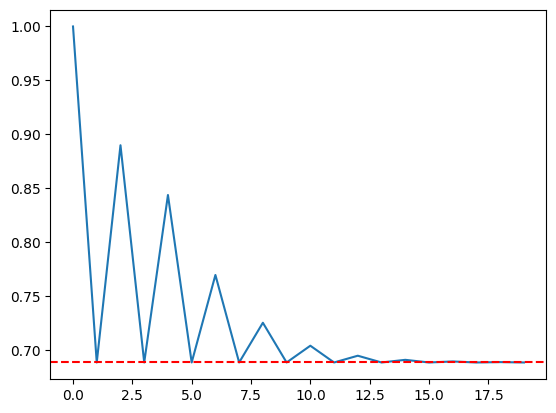

In [184]:
plt.plot(np.diff(list(entropies.values())))
# add horizontal line at entropy_Rate
plt.axhline(entropy_rate, color='r', linestyle='--')

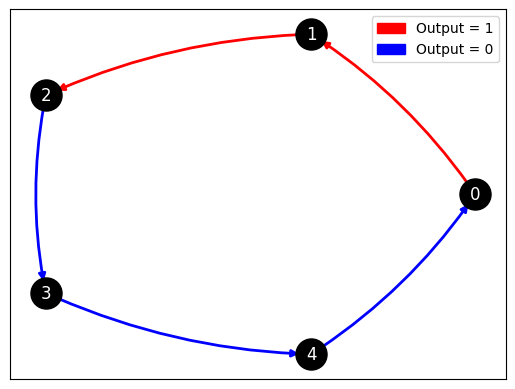

states=[0, 1, 2, 3, 4] transition_function={'01': 1, '11': 2, '20': 3, '30': 4, '40': 0} emmision_0_probs=array([0., 0., 1., 1., 1.]) transition_matrix=array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]]) transition_output_matrix=array([[nan, nan, nan, nan,  0.],
       [ 1., nan, nan, nan, nan],
       [nan,  1., nan, nan, nan],
       [nan, nan,  0., nan, nan],
       [nan, nan, nan,  0., nan]])


In [54]:
# Define the FSM for a period 5 process
transition_function = {
    '01': 1, '11': 2, '20': 3, '30': 4, '40': 0
}
emission_0_probs = np.array([0., 0., 1., 1., 1.])
fsm = FiniteStateMachine(states=list(range(5)), transition_function=transition_function, emmision_0_probs=emission_0_probs)

plot_from_transition_matrix(fsm)
print(fsm)

In [55]:
# Calculate entropy rate and statistical complexity
entropy_rate, statistical_complexity = calculate_entropy_and_complexity(fsm)
print(f"Entropy Rate: {entropy_rate}")
print(f"Statistical Complexity: {statistical_complexity}")
# print log_2 of 5
print(np.log(5))

Entropy Rate: 0.0
Statistical Complexity: 2.3219280948873626
1.6094379124341003


c:\Users\adamimos\Documents\GitHub\epsilon-transformers\clean_code\utils.py:123: ComplexWarning: Casting complex values to real discards the imaginary part
  joint_prob_dist[state, 1] = steady_state_distribution[state][0] * (1 - fsm.emmision_0_probs[state])
c:\Users\adamimos\Documents\GitHub\epsilon-transformers\clean_code\utils.py:121: ComplexWarning: Casting complex values to real discards the imaginary part
  joint_prob_dist[state, 0] = steady_state_distribution[state][0] * fsm.emmision_0_probs[state]


c:\Users\adamimos\anaconda3\envs\analysis\lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


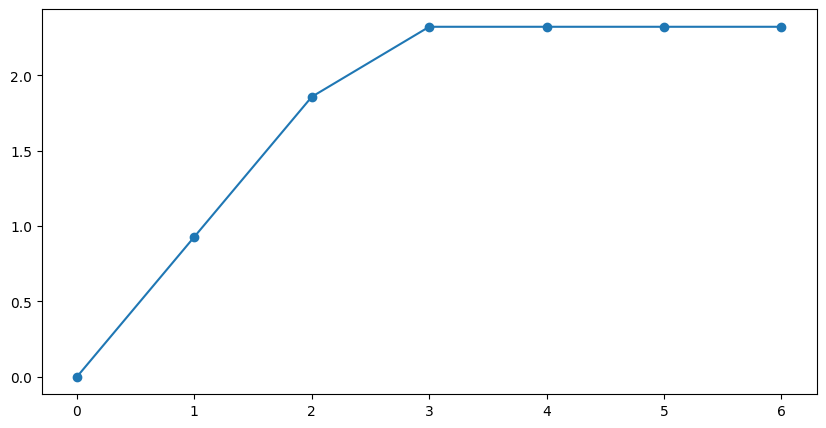

In [56]:
# Test the function
sequence_probs = calculate_sequence_probabilities(fsm, 6)
entropies = calculate_block_entropies(sequence_probs)

# plot the entropies
plt.figure(figsize=(10, 5))
plt.plot(entropies.keys(), entropies.values(), 'o-')

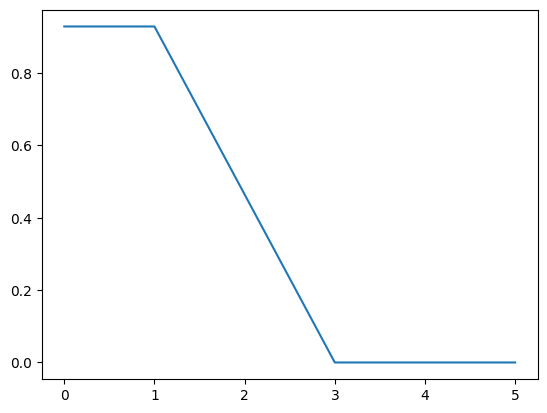

In [57]:
plt.plot(np.diff(list(entropies.values())))

In [58]:
print(fsm)

states=[0, 1, 2, 3, 4] transition_function={'01': 1, '11': 2, '20': 3, '30': 4, '40': 0} emmision_0_probs=array([0., 0., 1., 1., 1.]) transition_matrix=array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]]) transition_output_matrix=array([[nan, nan, nan, nan,  0.],
       [ 1., nan, nan, nan, nan],
       [nan,  1., nan, nan, nan],
       [nan, nan,  0., nan, nan],
       [nan, nan, nan,  0., nan]])
